In [12]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define charts settings
plt.rc('xtick',labelsize=14)
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["legend.framealpha"] = 1

# List of text titles in the same order as in FIG. 2a in the article
text_names_sorted = ('genesisA', 'genesisB', 'ChristI', 'ChristII', 'ChristIII', 'Elene', 'Juliana',
                     'KD_1', 'KD_2', 'Klaeber_part1', 'Klaeber_part2', 'ILIAD', 'ODYSSEY')


<h1><i>Functions</i></h1>

In [13]:
def process_file(dir_, file):
    '''
    Read file and split the text to lines
    '''

    # Read file
    with open(os.path.join(dir_, file)) as f:
        x = f.read()    

    # Remove blankspaces
    x = re.sub(' +', '', x)

    # Remove initial and final hashtag
    x = re.sub('^#|#$', '', x)
            
    # Return list of lines and text_name
    return x.split('#'), re.sub('\.txt$', '', file)


def pauses_ratio(text, punctuation):
    '''
    Calculate the ratio of intra-line to all sense-pauses
    '''
        
    all_pauses = 0
    intra_pauses = 0
    
    # Iterate over lines of text
    for line in text:

        # Replace subsequent punctuation with a single dot
        # (in order to count consecutive punctuation marks as a single character)
        line = re.sub('[' + ''.join(punctuation) + ']+', '.', line)
        
        # Iterate over characters
        for i, char in enumerate(line):
            # ...if it is a punctuation mark from a defined set
            if char == '.':
                all_pauses += 1
                        
                # ... if it is in intra-line position
                if i < len(line) - 1:
                    intra_pauses += 1
        
    # Return the intra-line to all sense-pauses ratio
    return intra_pauses / all_pauses


def plot_chart(data, text_names_sorted):
    '''
    Plot ratios into a bar chart
    '''

    x = np.arange(len(text_names_sorted))
    plt.xticks(x, text_names_sorted, rotation='vertical')
    
    i = 0
    for label in sorted(data):
        if len(data) > 1:
            position = i*0.5 / len(data) - 0.125
        else:
            position = 0
        plt.bar(x+position, data[label], width=0.15, label=label)
        i += 1
    plt.legend(loc='lower right')
    plt.show()
    plt.clf()
    

<h1>Replicate original chart</h1>
<p>First we replicate the FIG. 2a using the same procedure as in authors' <a href='https://github.com/qcrit/NHB-2018-OEstylometry/tree/master/sense_pauses' target='_blank'>original script</a>.

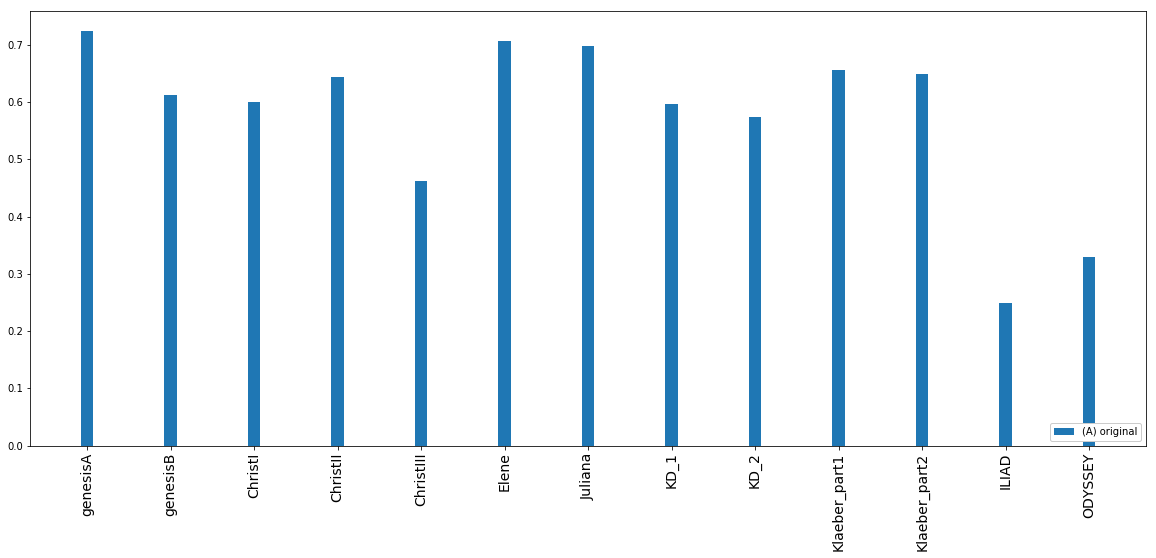

In [14]:
texts = dict()
ratios = dict()

ratios['(A) original'] = list()

# Define relevant punctuation marks as in script by Neidorf et al.
punctuation = ['!', ';', '?', '.', ':', '(', ')']

# Directory "src/selected" - the one where files actually used for the experiment are stored in
dir_ = os.path.join('src', 'selected')

# Read the texts and split them to lines
for file in os.listdir(dir_):
    text, text_name = process_file(dir_, file)
    texts[text_name] = text

# Calculate the ratios
ratios_original = list()
for text_name in text_names_sorted:    
    ratio = pauses_ratio(texts[text_name], punctuation)
    ratios['(A) original'].append(ratio)

# Plot the chart
plot_chart(ratios, text_names_sorted)    


<h1>Fix Genesis A/B issue</h1>
<p>Unfortunately the original data for Genesis A/B are corrupted. File genesisA.txt actually contains lines 1-234 of Genesis A + first line of Genesis B, while file genesisB.txt contains all the remaining lines of Genesis A (852-2936). The original chart thus shows a 'marked difference' between two pieces of the same text.
<p>To fix this we read the entire Genesis stored in 'src/corpus/genesis.txt' and split it on our own: Genesis A ~ lines 1-234 + lines 852-2936, Genesis B ~ lines 235-851.

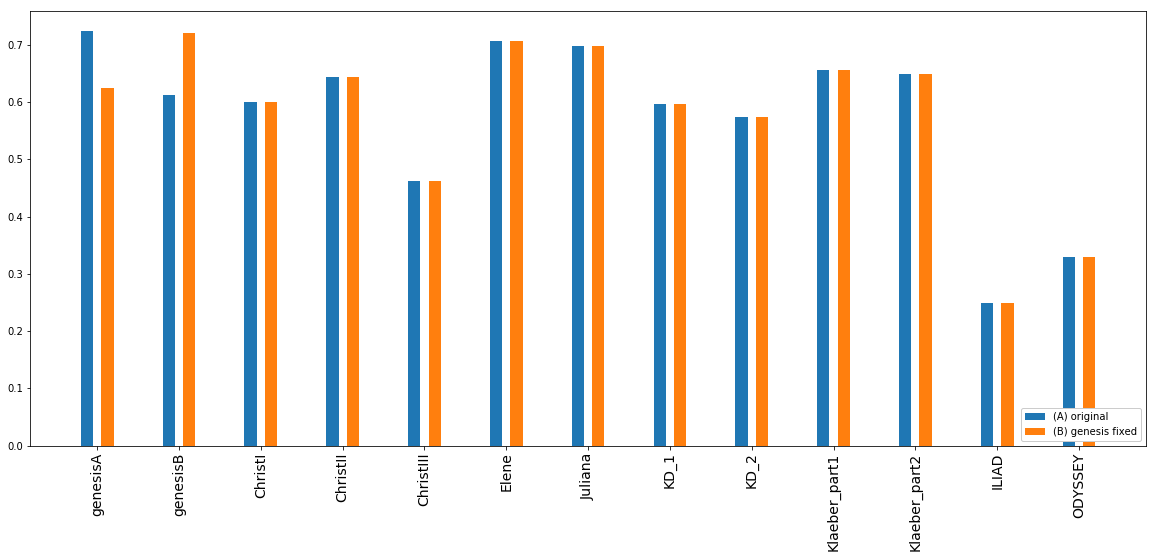

In [15]:
texts = dict()
dir_ = os.path.join('src', 'selected')
ratios['(B) genesis fixed'] = list()

# Read the texts and split them to lines
for file in os.listdir(dir_):
    # ... but skip Genesis A and Genesis B this time
    if file.startswith('genesis'):
        continue
    text, text_name = process_file(dir_, file)
    texts[text_name] = text

# Read Genesis from a single file and split it to A and B according to line numbers
text, text_name = process_file(os.path.join('src', 'corpus'), 'genesis.txt')
texts['genesisA'] = text[0:234] + text[851:]
texts['genesisB'] = text[234:851]

# Calculate the ratios
ratios_genesis_fixed = list()
for text_name in text_names_sorted:    
    ratio = pauses_ratio(texts[text_name], punctuation)
    ratios['(B) genesis fixed'].append(ratio)

# Plot the chart
plot_chart(ratios, text_names_sorted)    


<h1>Add missing punctuation and remove commas</h1>
<p>In the 'Methods' section of the article (p. 7) sense-pauses marks are enumerated as follows: <span style='color: green; font-weight: bold'> . ? ! ; : ( ) - ‘ ’ “ ”</span>, but in the original script the last five characters (dashes, quotes and double quotes) are not taken into account. This also causes errors: for instance in line <span style='color: green; font-weight: bold'>mid soðfæder symle wunian . "</span> the period is incorrectly classified as intra-line because it is followed by other character. We fix this simply by extending the list of relevant punctuation.
<p>For similar reasons we also delete all commas - as they are not treated as relevant punctuation, they cause e.g. right bracket in <span style='color: green; font-weight: bold'>fæmnan lufian , ( hine fyrwet bræc ) ,</span> to be incorrectly classified as intra-line.

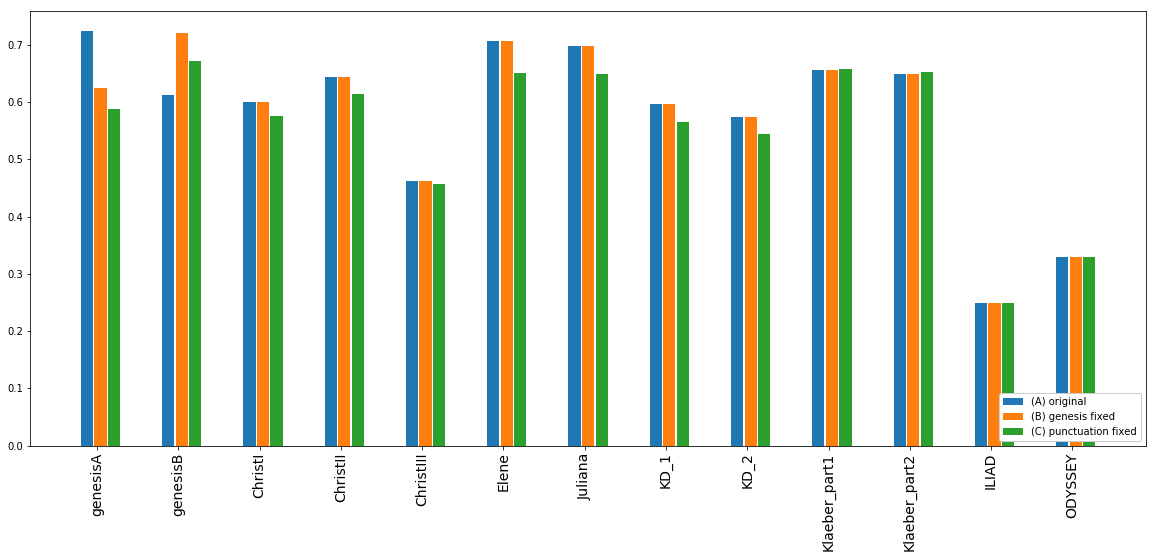

In [16]:
ratios['(C) punctuation fixed'] = list()

# Extend the list of relevant punctuation
punctuation.extend(['\"', '\-', '\—' ])

# Calculate the ratios
for text_name in text_names_sorted:
    text_wo_trash = list()
    # ... but first delete commas
    for line in texts[text_name]:
        text_wo_trash.append(re.sub(',', '', line))
    ratio = pauses_ratio(text_wo_trash, punctuation)
    ratios['(C) punctuation fixed'].append(ratio)

# Plot the chart
plot_chart(ratios, text_names_sorted)   

<h1>Remove sequences of dots</h1>

<p>Finally there are places in OE texts where sequences of dots are used to indicate missing pieces of texts (<span style='color:green; font-weight:bold'>þæt geond eorðb . . . . . .g eall eagna gesihþe</span>), not the punctuation. To disregard these cases we delete all the sequences of more dots in a row.

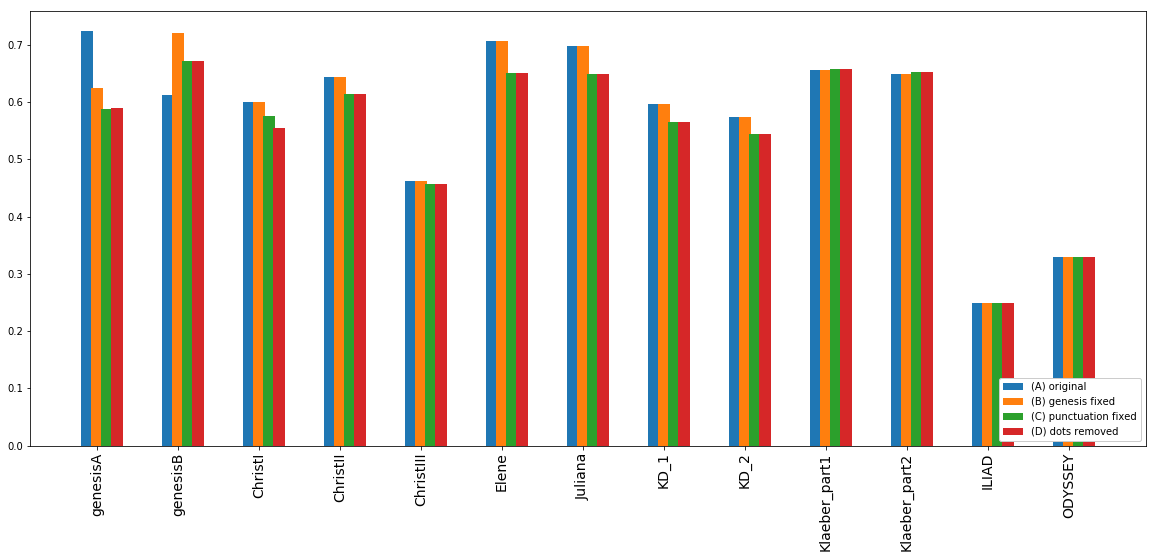

In [17]:
ratios['(D) dots removed'] = list()

# Calculate the ratios
for text_name in text_names_sorted:
    text_wo_dots = list()
    # ... but first:
    for line in texts[text_name]:
        # ... delete commas
        line_modified = re.sub(',', '', line)
        # ... delete all sequences of dots
        line_modified = re.sub('\.\.+', '', line_modified)
        text_wo_dots.append(line_modified)
    ratio = pauses_ratio(text_wo_dots, punctuation)
    ratios['(D) dots removed'].append(ratio)

# Plot the chart
plot_chart(ratios, text_names_sorted)   

<h1>Final chart</h1>
<p>Now simply plot only the first series (original data presented in the article) and the last one (all issues fixed) to see that the differences are sometimes really striking.

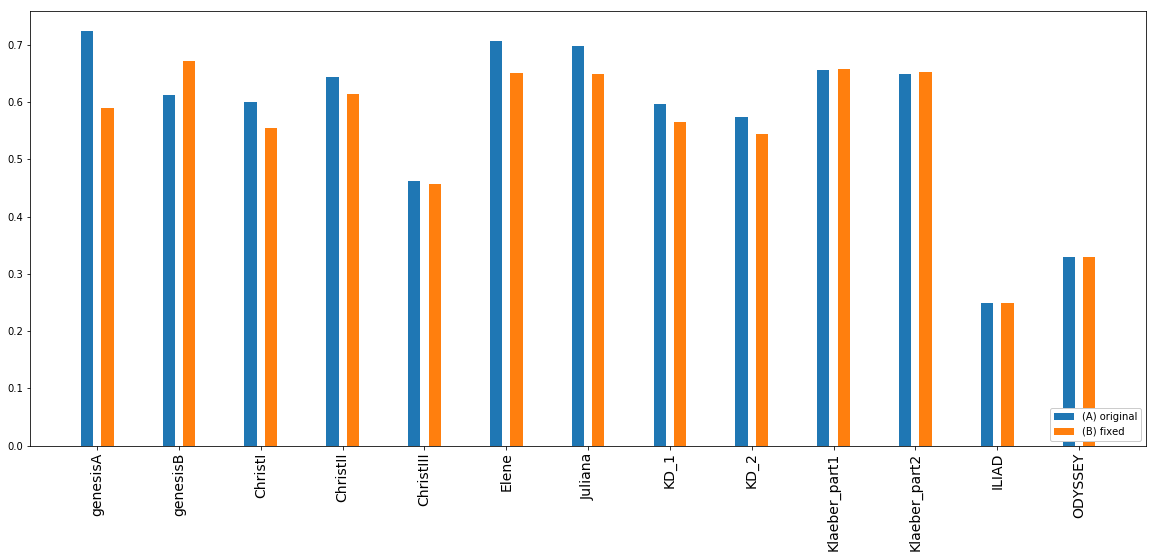

In [18]:
ratios_final = {
    '(A) original': ratios['(A) original'],
    '(B) fixed': ratios['(D) dots removed'],
}

# Plot the chart
plot_chart(ratios_final, text_names_sorted)   

Text(0.5,0,'')

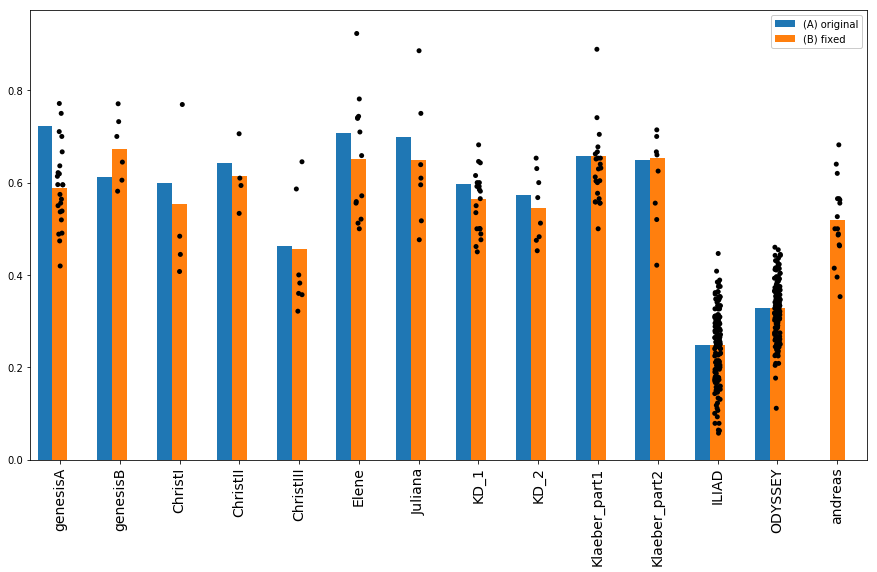

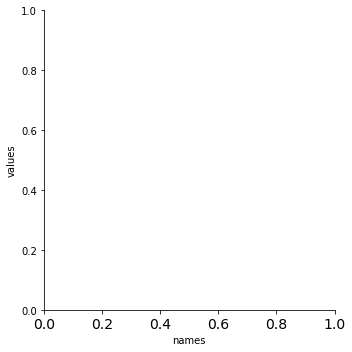

In [19]:
import seaborn as sns
import pandas as pd
from scipy import stats
import itertools
import random

text_names_sorted = text_names_sorted + ('andreas',)
ratios_final['(A) original'].append(0)
texts['andreas'], text_name = process_file(os.path.join('src', 'corpus'), 'andreas.txt')

text_wo_dots = list()
for line in texts['andreas']:
    # ... delete commas
    line_modified = re.sub(',', '', line)
    # ... delete all sequences of dots
    line_modified = re.sub('\.\.+', '', line_modified)
    text_wo_dots.append(line_modified)
ratio = pauses_ratio(text_wo_dots, punctuation)
ratios_final['(B) fixed'].append(ratio)

def sampling(texts, n=300, step=300):
    '''
    texts:  {dict} of texts 
    n:      number of lines in one sample
    step:   after how many lines new sample should start (set step = n to get non-overlapping samples)
    '''
    
    samples = defaultdict(lambda: defaultdict(list))
    
    # Iterate over texts
    for text_name in texts:

        # Restart samples indexing for each new text
        sample_indices = [1]

        # Iterate over lines of text
        for i, line in enumerate(texts[text_name]):

            # Iterate over current sample indices
            for si in sample_indices:
                samples[text_name][si].append(line)
                    
            # Add new sample index if step was reached  
            if (i+1) % step == 0 and i > 1 and len(texts[text_name]) > i + n:
                sample_indices.append( sample_indices[-1] + 1 )

            # Remove first sample index if it reached the size
            if len(sample_indices) > 0 and len(samples[text_name][sample_indices[0]]) == n:
                sample_indices = sample_indices[1:]
                
    return samples

samples = sampling(texts, n=100, step=100)

# Calculate the ratios
scatter_data = defaultdict(list)
ratios_samples = defaultdict(list)

for text_name in text_names_sorted:
    for si in samples[text_name]:
        text_wo_dots = list()
        # ... but first:
        for line in samples[text_name][si]:
            # ... delete commas
            line_modified = re.sub(',', '', line)
            # ... delete all sequences of dots
            line_modified = re.sub('\.\.+', '', line_modified)
            text_wo_dots.append(line_modified)
        ratio = pauses_ratio(text_wo_dots, punctuation)
        scatter_data['names'].append(text_name)
        scatter_data['values'].append(ratio)
        ratios_samples[text_name].append(ratio)

scatter_data = pd.DataFrame.from_dict(scatter_data)

a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

x = np.arange(len(text_names_sorted))
plt.xticks(x, text_names_sorted, rotation='vertical')
    
i = 0
for label in sorted(ratios_final):
    if len(ratios_final) > 1:
        position = i*0.5 / len(ratios_final) - 0.25
    else:
        position = 0
    ax.bar(x+position, ratios_final[label], width=0.25, label=label)
    i += 1
sns.catplot(x="names", y="values", data=scatter_data, jitter=0.05, ax=ax, color='black')
ax.legend(loc='upper right')
ax.set_ylabel('')    
ax.set_xlabel('')
    

In [20]:
for text in list(itertools.combinations(text_names_sorted, 2)):
    t = stats.ttest_ind(ratios_samples[text[0]],ratios_samples[text[1]])
    print(text[0], text[1])
    print('\t', t)
    print('\t n1 = {0}, n2 = {1}'.format(len(ratios_samples[text[0]]), len(ratios_samples[text[1]]) ))

genesisA genesisB
	 Ttest_indResult(statistic=-2.0679739609529015, pvalue=0.048346344485947788)
	 n1 = 23, n2 = 6
genesisA ChristI
	 Ttest_indResult(statistic=1.1794507158191299, pvalue=0.24932152286265144)
	 n1 = 23, n2 = 4
genesisA ChristII
	 Ttest_indResult(statistic=-0.42543267870853901, pvalue=0.67416121695874565)
	 n1 = 23, n2 = 4
genesisA ChristIII
	 Ttest_indResult(statistic=3.659652452240798, pvalue=0.0010382318992895241)
	 n1 = 23, n2 = 7
genesisA Elene
	 Ttest_indResult(statistic=-1.7659115695565577, pvalue=0.086389941700252104)
	 n1 = 23, n2 = 13
genesisA Juliana
	 Ttest_indResult(statistic=-1.0997197572180915, pvalue=0.28081987052362267)
	 n1 = 23, n2 = 7
genesisA KD_1
	 Ttest_indResult(statistic=1.4491935320058629, pvalue=0.15453777289874368)
	 n1 = 23, n2 = 22
genesisA KD_2
	 Ttest_indResult(statistic=1.2493716654942724, pvalue=0.22151942441340161)
	 n1 = 23, n2 = 8
genesisA Klaeber_part1
	 Ttest_indResult(statistic=-1.5807573378072379, pvalue=0.12109632013869043)
	 n1 =